# Gathering Insight from Kickstarter Data: Machine Learning

_A project by Team Apple (Data Mining & Machine Learning, HEC Lausanne, Fall 2019)_

**Contents**

1. [Introduction](#intro)
2. [Setting things up](#imports)
3. [Machine learning models](#ml)
    1. [Logistic regression](#logr)
    2. [k-nearest neighbors](#knn)
    3. [Decision tree](#dt)
    4. [Random forest](#rf)
    5. [Neural network](#nn)
    6. [(Bonus!) Linear regression](#linr)
4. [Conclusion](#conclusion)

## 1. Introduction<a name="intro"></a>

_This is the follow-up to the exploratory data analysis done in [this notebook](https://github.com/tbacha/DMML2019_Team_Apple/blob/master/code/Kickstarter_notebook_Team_Apple_EDA.ipynb)._

### Quick reminder

* We are trying to find a **machine learning model** that can accurately predict the success or failure of a Kickstarter project, and which features are the best to use.
* The predicted classes are either **1** (= successful) or **0** (= failed).
* The base rate of the majority class (failed) is **63.66%**.

We thought it would be interesting to try all the classification models seen during the course (in the same order) and pit them against each other to see which one (if any at all) would perform best with our dataset.

### Feature selection

Of all features available in the dataset, only the following were considered:

* `usd_goal_real`: the goal set by the project creator (in USD)
* `elapsed_time`: the time that passed between the launch date and the deadline 
* `category`: the specific category chosen for the project
* `main_category`: the main category chosen for the project
* `country`: where the project originates from

The reason for this choice is that these features can be somewhat controlled by the project creator. Other features, such as `backers` or `usd_pledged_real`, are rather indicators of whether a project is being successful or not, and the project creator has no direct control over them.

### Methodology

The same methodology was applied for each model:

1. Test each feature _separately_ to see their marginal contribution to the given model's accuracy.
2. Test various combinations of features and scaling/encoding schemes in an exploratory fashion, in an attempt to find the most accurate model.
3. Fine-tune the model by adjusting the parameters.

**Numerical** features were tested either in their original form or in a normalized version. The two types of scaling used were _z-score normalization_ (standard) and _min-max normalization_.

**Categorical** features were encoded using either _one-hot encoding_ or _label encoding_ to make them usable by our models. As we will see, the choice between the two is not trivial and highly depends on the model used.

In order to shorten the computation time, we applied **dimensionality reduction** (PCA) in some cases (especially when using one-hot encoding).

To measure **accuracy**, we used scikit-learn's _score_ function. Since our classes are not that well balanced (a ratio of about 2:1), we initially also looked at scikit-learn's classification report, which contains other useful metrics such as precision and recall. However, our first tests show that, generally speaking, as accuracy goes up, so do precision and recall. Recall is generally quite good for the negative class (\~80%) and quite bad for the positive class (\~40%). To speed up the analysis process, we decided not to pay any further attention to these metrics.

## 2. Setting things up<a name="imports"></a>

The following libraries are necessary for the neural network to work. If not already installed, these commands need to be uncommented and called.

In [2]:
#!pip install keras
#!pip install --upgrade tensorflow==1.14.0

The `cleaning` module contains the **cleaned version** of the dataset (see the <a href="https://github.com/tbacha/DMML2019_Team_Apple/blob/master/code/Kickstarter_notebook_Team_Apple_EDA.ipynb" target="_blank">EDA notebook</a> for detailed explanations about the cleaning process).

The `custom_functions` module contains a custom version of scikit-learn's `train_test_split` function, designed to make it easier to play with different feature combinations, scaling/encoding schemes, dimensionality reduction, etc. (see <a href="https://github.com/tbacha/DMML2019_Team_Apple/blob/master/README.md" target="_blank">README</a> for more information about the parameters).

If using this notebook online, please copy the contents of these files to new cells (and run them) instead of importing them.

In [6]:
from cleaning import df
from custom_functions import custom_split

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

from keras import optimizers
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

In order to get reproducible as well as comparable results, we arbitrarily chose a **random seed** to be used during the train/test split and as a parameter for some models.

In [2]:
RSEED = 42

All the main **test results** were recorded in `documents/ml_results.xlsx`. Parts of it are shown in this notebook, but please refer to the original file for a complete overview.

In [3]:
url = "https://github.com/tbacha/DMML2019_Team_Apple/blob/master/documents/ml_results.xlsx?raw=true"
results = pd.read_excel(url, sheet_name=None)

## 3. Machine learning models<a name="ml"></a>

Before going into the details of each model, here is an overview of how they performed against the base rate (best scores). As you can see, compared to random guessing, machine learning enables us to increase accuracy by about **4** to **6%**.

Text(0, 0.5, 'Accuracy')

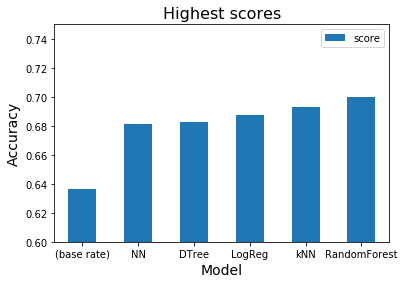

In [5]:
data = {"model":["(base rate)","LogReg","kNN","DTree","RandomForest","NN"], "score":[0.6366,0.6872,0.6931,0.6824,0.7002,0.6811]}
table = pd.DataFrame(data).sort_values(by="score", ascending=True)
ax = table.plot.bar(x="model", y="score", rot=0)
ax.set_ylim(0.6, 0.75)
ax.set_title("Highest scores", size=16)
ax.set_xlabel("Model", size=14)
ax.set_ylabel("Accuracy", size=14)

### A. Logistic regression<a name="logr"></a>

In [6]:
X_train, X_test, y_train, y_test = custom_split(data=df, predict="state", rseed=RSEED,
                                                scaling="std", encoding="onehot",
                                                pca=False, poly=False,
                                                features=["goal", "time", 
                                                          "category", "main_category", "country"])

LR = LogisticRegressionCV(solver="lbfgs", cv=5, max_iter=1000, random_state=RSEED)
LR.fit(X_train, y_train)
LR.score(X_test, y_test)

0.6872265139646696

#### Results

Testing each feature separately, we find that `category` (one-hot encoded) brings the highest marginal increase in accuracy. This make sense, since the one-hot encoded version contains 159 features. The next best feature is `main_category` (again, with one-hot encoding).

In [33]:
data = {"feature":["Goal(STD)","Time(STD)","Category(OH)","MainCategory(OH)","Country(OH)"], "score":[0.6377,0.6377,0.6714,0.6498,0.6377]}
pd.DataFrame(data).sort_values(by="score", ascending=False).style.hide_index()

feature,score
Category(OH),0.6714
MainCategory(OH),0.6498
Goal(STD),0.6377
Time(STD),0.6377
Country(OH),0.6377


Generally speaking, adding more features to a logistic regression model results in higher accuracy (at the cost of a longer runtime, since the complexity depends on the number of features).

This leads us to the conclusion that, in most cases, it is better to **combine** features (e.g. goal + category) to get better accuracy. The table below shows that. However, it is worth noting that the resulting increase is very small. Simply by using the one-hot-encoded `category`, we get an accuracy of 67.14%. Using all the other features alongside it only contributes a 1.58% increase.

In [36]:
results["LogisticRegression"].loc[[0,1,2,4,10,12],:].fillna("-")

,goal,time,category,main_category,country,accuracy
0,STD,STD,OH,OH,OH,0.687227
1,STD,STD,OH,OH,-,0.686632
2,STD,STD,OH,-,-,0.686214
4,STD,-,OH,-,-,0.680730
10,-,-,OH,-,-,0.671358
12,-,-,-,OH,-,0.649789


**Note**: numerical values need to be normalized if one hopes to increase the model accuracy. Since min-max normalization often leads to convergence errors (even doubling the number of iterations did not help), the more successful tests use standard scaling.

### B. k-nearest neighbors<a name="knn"></a>

k-NN is known to become exponentially more inefficient as the number of features increases. For this reason, we initially thought that one-hot encoding, which worked well for a parametric algorithm like logistic regression, could not be used here and that we would have to resort to **label encoding**.

However, it is still possible to use one-hot encoding by reducing the dimensionality with **PCA** (e.g. to 2). This speeds up runtime considerably and gives surprisingly good results (at even lower values of $k$), but the accuracy is _slightly_ worse than label encoding, as can be seen below.

We first ran a battery of tests at $k\geq49$, then pushed the value of $k$ up to 99 to see if the best-performing sets of features could provide us with an even better accuracy.

In [9]:
X_train, X_test, y_train, y_test = custom_split(data=df, predict="state", rseed=RSEED,
                                                scaling="minmax", encoding="label",
                                                pca=False, poly=False,
                                                features=["goal", "time", 
                                                          "category", "main_category"])

scores = []
k_lim = 100

for k in range(1, k_lim, 2):
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train, y_train)
    score = KNN.score(X_test, y_test)
    scores.append(score)

In [17]:
i = np.argmax(scores)
print(i*2+1, scores[i])

95 0.6931149046512884


In [31]:
X_train, X_test, y_train, y_test = custom_split(data=df, predict="state", rseed=RSEED,
                                                scaling="minmax", encoding="onehot",
                                                pca=2, poly=False,
                                                features=["goal", "time", 
                                                          "category", "main_category"])

scores = []
k_lim = 100

for k in range(1, k_lim, 2):
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train, y_train)
    score = KNN.score(X_test, y_test)
    scores.append(score)

In [33]:
i = np.argmax(scores)
print("With one-hot encoding + PCA=2:", i*2+1, scores[i])

With one-hot encoding + PCA=2: 65 0.6925746853222409


#### Results

In [5]:
results["kNearestNeighbors"].loc[[0,1,2,3,4,5,6,7,8,13],:].fillna("-")

,goal,time,category,main_category,country,pca,k,accuracy
0,MM,MM,LE,LE,-,-,95,0.693115
1,MM,MM,OH,OH,-,2,65,0.692575
2,MM,MM,LE,LE,LE,-,79,0.692237
3,MM,MM,LE,LE,-,-,49,0.691076
4,MM,MM,LE,LE,LE,-,47,0.690941
5,MM,MM,LE,-,-,-,49,0.690684
6,STD,STD,LE,LE,-,-,47,0.690468
7,STD,STD,LE,-,-,-,47,0.690130
8,STD,STD,LE,LE,LE,-,41,0.689576
13,STD,STD,OH,OH,-,2,95,0.660405


From this data, a couple of interesting points arise:

* Overall, the k-NN model performed **better** than logistic regression (we managed to go over the 69% threshold!).
* Contrary to logistic regression, it seems that _removing_ a feature (in this case `country`) can actually lead to an increase in accuracy (albeit very small).
* Increasing the value of $k$ _does_ provide a little bit accuracy (about 0.2% going from $k=49$ to $k=99$), but at the cost of longer computation time. As shown in the graph below, any value of $k$ above 35 gives good enough results. 
* Min-max encoding seems to perform better, but in the case of label encoding, the difference is so small it is hardly worth mentioning.
* Testing single features again showed that **`category`** is the largest contributing factor of accuracy.

Since the difference between label encoding and one-hot encoding (with PCA) is so small, we recommend using the latter for faster runtime.

**Note**: a weird thing we noticed is that running the k-NN on a single feature takes much longer than running the same model with several features). We were not able to make sense of this.

Furthermore, k-NN is not supposed to work well with categorical data, because the hierarchy of labels (from 1 to $n$) is completely arbitrary and meaningless. Yet, it performed better than logistic regression. Again, we cannot provide an explanation for this.

Text(0.5, 0, 'k')

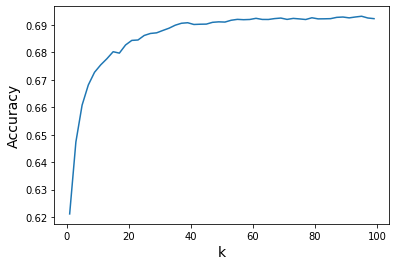

In [18]:
plt.plot(range(1, k_lim, 2), scores)
plt.ylabel("Accuracy", size=14)
plt.xlabel("k", size=14)

### C. Decision tree<a name="dt"></a>

In [60]:
X_train, X_test, y_train, y_test = custom_split(data=df, predict="state", rseed=RSEED,
                                                scaling="std", encoding="label",
                                                pca=False, poly=False,
                                                features=["goal", "time", 
                                                          "category", "main_category", "country"])

scores = []

for d in range(1, 30):
    DT = DecisionTreeClassifier(criterion="entropy", max_depth=d, random_state=RSEED)
    DT.fit(X_train, y_train)
    scores.append(DT.score(X_test, y_test))

In [61]:
i = np.argmax(scores)
print(i+1, scores[i])

12 0.6883204581059911


In [10]:
X_train, X_test, y_train, y_test = custom_split(data=df, predict="state", rseed=RSEED,
                                                scaling="std", encoding="onehot",
                                                pca=4, poly=False,
                                                features=["goal", "time", 
                                                          "category", "main_category", "country"])

scores = []

for d in range(1, 15):
    DT = DecisionTreeClassifier(criterion="entropy", max_depth=d, random_state=RSEED)
    DT.fit(X_train, y_train)
    scores.append(DT.score(X_test, y_test))
i = np.argmax(scores)
print(i+1, scores[i])

11 0.6572848576522068


#### Results

The first thing that stands out after running tests with different features is that `category` (no matter which encoding) _still_ remains the most relevant feature to increase accuracy.

Also, we see yet again that adding more features to the decision tree makes it more accurate (our best score was achieved by keeping all 5 of them).

That being said, simply combining the `usd_goal_real` feature with `category` gave us an accuracy rivalling with that of the best score (68.23% vs 68.83%). This is consistent with what was observed for logistic regression, thus further increasing our belief that the goal and the category have **good synergy**.

In [49]:
results["DecisionTree"].loc[[0,1,2,3,4,5,13],:].fillna("-")

,goal,time,category,main_category,country,d,accuracy
0,raw,raw,LE,LE,LE,12,0.688320
1,STD,STD,LE,LE,LE,12,0.688320
2,STD,STD,LE,LE,-,12,0.688293
3,raw,raw,LE,LE,-,12,0.688280
4,raw,raw,OH,OH,OH,14,0.686578
5,STD,STD,OH,OH,OH,14,0.686524
13,MM,-,LE,-,-,12,0.682378


Furthermore, we can make the following observations:

* For decision trees, the type of encoding for categorical variables does not seem to matter much. Therefore, it is advised to pick **label encoding** for faster runtime.
* As expected, normalizing the numerical data does not affect the model's accuracy.
* As shown in the graph below, there is no need to go very deep in the tree to reach a good level of accuracy.
* There are no significant differences between the two main attributes/thresholds picking schemes, i.e. Gini coefficient and entropy (the latter provided slightly better results).
* We are now quite sure that the `country` is mostly **irrelevant**.

Overall, decision trees might not provide the best accuracy of all the models considered in this project (although they come quite close), but its **computation time** is perceptibly shorter; this makes it a very attractive model.

Text(0.5, 0, 'Depth')

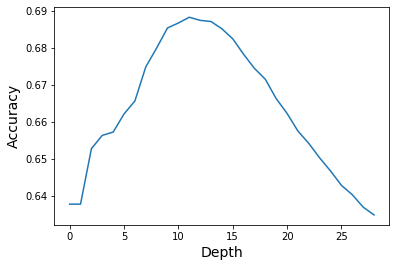

In [62]:
plt.plot(scores)
plt.ylabel("Accuracy", size=14)
plt.xlabel("Depth", size=14)

Finally, we thought it would be good to look at the **importance** of each feature. Interestingly, `elapsed_time`, followed by the `usd_goal_real` feature, contribute the most to decreasing node impurity. Among categorical features, as previously suspected, `category` is the most discriminant when it comes to information gain.

In [59]:
list(zip(X_train.columns, DT.feature_importances_))

[(0, 0.25417221151490066),
 (0, 0.5438532786198623),
 ('category', 0.11474526123842048),
 ('main_category', 0.05081218348749061),
 ('country', 0.036417065139325897)]

### D. Random forest<a name="rf"></a>

After having experimented with decision trees, the next logical step was to try the related random forest ensemble (mostly because we were curious to see by how much accuracy would actually increase compared to decision trees).

Random forests being quite **intensive** in terms of computation, we did not run as many tests as with previous models (especially not the ones with one-hot encoding!). To wit, we only picked the set of features that worked best for decision trees.

In [63]:
X_train, X_test, y_train, y_test = custom_split(data=df, predict="state", rseed=RSEED,
                                                scaling=None, encoding="label",
                                                pca=False, poly=False,
                                                features=["goal", "time",
                                                          "category", "main_category", "country"])

scores = []

for d in range(1, 30):
    RF = RandomForestClassifier(criterion="entropy", n_estimators=100, max_depth=d, random_state=RSEED)
    RF.fit(X_train, y_train)
    scores.append(RF.score(X_test, y_test))

In [65]:
i = np.argmax(scores)
print(i+1, scores[i])

16 0.7001512614121334


Text(0.5, 0, 'depth')

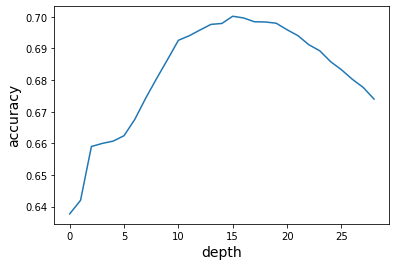

In [66]:
plt.plot(scores)
plt.ylabel("accuracy", size=14)
plt.xlabel("depth", size=14)

#### Results

In [69]:
results["RandomForest"].loc[:,:].fillna("-")

,goal,time,category,main_category,country,d,accuracy
0,raw,raw,LE,LE,LE,16,0.700151
1,STD,STD,LE,LE,LE,17,0.699895
2,MM,MM,LE,LE,LE,18,0.699192


Building up on the effectiveness of decision trees, random forests gave us our best score yet; we have now gone above the **70%** threshold, meaning more than 6% better than the baseline approach.

It should be noted, however, that the computation time goes through the roof, especially when trying to find the optimal value for $d$. Once you know it, fitting the random forest takes about 1.5 to 2 minutes (whereas a single decision tree takes only 2-3 seconds)!

Of course, it is possible to lower the computation time by picking a lower **number of estimators** (say 10), but this means a trade-off between computation time and accuracy. In such conditions, the random forest does not perform much better than the decision tree. 

### E. Neural network<a name="nn"></a>

As our final classification model, we were curious to experiment briefly with neural networks. However, the analysis conducted with previous models already told us much about the relevance of each feature; following the TA's advice, we did not spend too much time exploring neural networks and restricted ourselves to the set of parameters and the layer configuration seen during the course.

In [72]:
X_train, X_test, y_train, y_test = custom_split(data=df, predict="state", rseed=RSEED,
                                                scaling="std", encoding="onehot",
                                                pca=False, poly=False,
                                                features=["goal", "time", 
                                                          "category", "main_category", "country"])

Y_train = np_utils.to_categorical(y_train, 2)
Y_test = np_utils.to_categorical(y_test, 2)

NN = Sequential()
NN.add(Dense(512, input_shape=(X_train.shape[1],)))
NN.add(Activation("relu"))
NN.add(Dropout(0.2))
NN.add(Dense(2))
NN.add(Activation("softmax"))

optimizer = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
NN.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

NN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               101888    
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
_________________________________________________________________
activation_5 (Activation)    (None, 2)                 0         
Total params: 102,914
Trainable params: 102,914
Non-trainable params: 0
_________________________________________________________________


In [73]:
model_hist = NN.fit(X_train, Y_train, batch_size=64, epochs=30, verbose=0, validation_split=0.2)

#### Results

We were disappointed to observe that, out of all the classifiers we tried, the neural network gave us the **worst** performance. That being said, the difference is so small that we might as well say it is insignificant. Moreover, adding more layers and adjusting other parameters would probably have yielded better results.

In terms of features, the previous observations still hold here: adding more features increases accuracy, but none more so than the specific `category`.

Finally, hearkening back to logistic regression, **standard scaling** and **one-hot encoding** seem to work the best on neural networks.

In [23]:
results["NeuralNetwork"].loc[:,:].fillna("-")

,goal,time,category,main_category,country,accuracy
0,STD,STD,OH,OH,OH,0.6811
1,STD,-,OH,OH,-,0.6718
2,MM,MM,OH,OH,OH,0.6706
3,-,-,OH,OH,OH,0.6703
4,-,-,OH,-,-,0.6666
5,MM,MM,LE,LE,LE,0.6448
6,-,-,LE,-,-,0.6405


### F. (Bonus!) Linear regression<a name="linr"></a>

As a side project, we also experimented with **linear regression** to see if the data allowed us to accurately predict the amount of money pledged to a certain project (`usd_pledged_real`).

In [7]:
X_train, X_test, y_train, y_test = custom_split(data=df, predict="usd_pledged_real", rseed=RSEED,
                                                scaling="std", encoding="onehot", 
                                                pca=False, poly=False,
                                                features=["time", "goal", 
                                                          "category", "main_category", "country"])

"""
ridge = RidgeCV()
ridge.fit(X_train, y_train)
print("R^2:", ridge.score(X_test, y_test))
print("MSE:", mean_squared_error(y_test, ridge.predict(X_test)))
"""

LinR = LinearRegression(fit_intercept=True)
LinR.fit(X_train, y_train)
print("R^2:", LinR.score(X_test, y_test))
print("MSE:", mean_squared_error(y_test, LinR.predict(X_test)))

R^2: 0.013445023293411018
MSE: 7757534563.273292


#### Results

In [4]:
results["LinearRegression"].loc[[0,1,2,3,4,15],:].fillna("-")

,goal,time,category,main_category,country,poly,r^2
0,STD,STD,OH,OH,OH,-,0.013445
1,-,-,OH,-,-,-,0.013090
2,-,-,-,OH,-,-,0.007043
3,STD,STD,-,OH,-,2,0.005222
4,STD,STD,LE,LE,LE,2,0.001451
15,STD,STD,-,OH,-,3,-131.084931


We quickly realized that linear regression gave very **low** (sometimes even negative...) **scores** and **high error**, no matter which features were used.

Using **higher polynomial functions** or **ridge regression** instead did not help either, not to mention it was not possible to use the one-hot encoded `category` (which, so far, has usually allowed us to reach higher scores); the computation becomes just too long and results in memory errors.

Nevertheless, a couple of observations can be scavenged from the data that we gathered:

* Taking categorical variables into account leads to higher scores.
* There is no difference between min-max and standard scaling.
* Label encoding does not make much sense in the context of linear regression. It is preferable to use one-hot encoding.
* Given the very low scores, adjusting the `fit_intercept` parameter does not affect results significantly.
* Polynomial functions do not fit the data well.

We therefore conclude that the features available in the dataset are not enough to make linear regression work. It is unfortunately not possible to use this model to make any meaningful predictions. 

## 4. Conclusion<a name="conclusion"></a>

We started out with around **380,000 records of Kickstarter project metadata**, hoping to use it to build an effective model for predicting the success or failure of a project.

After having experimented with various machine learning models, we come to the conclusion that the data contained in the dataset is **not sufficient to provide a reliable model**. Our best (and rather inefficient) model, the **random forest**, performed only 6.4% better than the baseline approach. No significant difference was found between the various classifiers (from 68.11% for the worst model, to 70.02% for the best). The most efficient one was the **decision tree**, taking only a couple of seconds to run and boasting an accuracy of almost 69%. The **k-NN** also deserves an honorable mention; with the help of PCA, it is able to push accuracy above 69% in a reasonably short time.

More knowledgeable data scientists will be able to **better fine-tune** the models we used, but it is our belief that they might only be able to squeeze 1 or 2 extra percents out of it at best.

Unfortunately, our dataset did not contain the **project descriptions**. Had that been the case, it would have been interesting to conduct **text analysis** on the whole corpus in order to predict the success/failure. Indeed, it is our assumption that, in addition to the video, the project description is a very important aspect of a Kickstarter project in terms of marketing, and that it can have a much greater impact on the amount of money collected than, say, the category or country.
 
Our dataset contains informative, but **basic** metadata that do not have strong interdependencies with the final state of projects. Despite the large number of records, it is **difficult to identify a well-defined trend**.

Still, based on the data we were working with, we can conclude that the **specific category** (`category`) coupled with the **goal** set by the project creator (`usd_goal_real`) are the most relevant features for predicting success or failure.

As mentioned above, the descriptions of the different projects would have given us more leads for analysis and thus would have allowed us to formulate some hypotheses related to the success of a project, such as:
 
* Marketing analysis and the financial means used to promote the project (before and after the launch of the Kickstarter campaign)
* Available resources
* Supply and demand analysis
* The level of innovation of the project
* etc.
 
This would undoubtedly have made our results more relevant.